**Классификация текстов**

Чтобы запускать и редактировать код, сохраните копию этого ноутбука себе (File->Save a copy in Drive...). Свою копию вы сможете изменять и запускать.



**Импорт библиотек для работы всего ноутбука**

In [ ]:
from google.colab import files # Для работы с файлами 
import numpy as np # Для работы с данными 
import pandas as pd # Для работы с таблицами
import matplotlib.pyplot as plt # Для вывода графиков
import os # Для работы с файлами
%matplotlib inline

from tensorflow.keras import utils # Для работы с категориальными данными
from tensorflow.keras.models import Sequential # Полносвязная модель
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation # Слои для сети
from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами и преобразования их в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями

from sklearn.preprocessing import LabelEncoder # Метод кодирования тестовых лейблов
from sklearn.model_selection import train_test_split # Для разделения выборки на тестовую и обучающую
from google.colab import drive # Для работы с Google Drive
import time # Импортируем библиотеку time

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Классификация текстов писателей

**Загрузка данных**

In [ ]:
!rm -R '/content/texts' # Проверяем наличие папки texts. Если есть, удаляем ее

In [ ]:
# Указываем путь к базе в Google Drive, создаем папку texts и извлекаем туда базу
!unzip -q '/content/drive/My Drive/Базы/Тексты писателей.zip' -d '/content/texts' 

In [ ]:
def readText(fileName): # Объявляем функции для чтения файла. На вход отправляем путь к файлу
  f = open(fileName, 'r')        # Задаем открытие нужного файла в режиме чтения
  text = f.read()                # Читаем текст
  text = text.replace("\n", " ") # Переносы строки переводим в пробелы
  
  return text                    # Возвращаем текст файла

className = ["О. Генри", "Стругацкие", "Булгаков", "Саймак", "Фрай", "Брэдберри"] # Объявляем интересующие нас классы
nClasses = len(className) # Считаем количество классов

In [ ]:
#Загружаем обучающие тексты

trainText = [] #Формируем обучающие тексты
testText = [] #Формируем тестовые тексты

#Формирование необходимо произвести следующим образом 
#Класс каждого i-ого эллемента в обучающей выборке должен соответствовать 
#классу каждого i-ого эллемента в тестовой выборке

for i in className: #Проходим по каждому классу
  for j in os.listdir('texts/'): #Проходим по каждому файлу в папке с текстами #
    if i in j: #Проверяем, содержит ли файл j в названии имя класса i
      
      if 'Обучающая' in j: #Если в имени найденного класса есть строка "Обучающая" 
        trainText.append(readText('texts/' + j)) #добавляем в обучающую выборку
        print(j, 'добавлен в обучающую выборку') #Выводим информацию
      if 'Тестовая' in j: #Если в имени найденного класса есть строка "Тестовая"
        testText.append(readText('texts/' + j)) #добавляем в обучающую выборку
        print(j, 'добавлен в тестовую выборку') #Выводим информацию
  print()

(О. Генри) Тестовая_20 вместе.txt добавлен в тестовую выборку
(О. Генри) Обучающая_50 вместе.txt добавлен в обучающую выборку

(Стругацкие) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Стругацкие) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Булгаков) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Булгаков) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Клиффорд_Саймак) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Клиффорд_Саймак) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Макс Фрай) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Макс Фрай) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Рэй Брэдберри) Обучающая_22 вместе.txt добавлен в обучающую выборку
(Рэй Брэдберри) Тестовая_8 вместе.txt добавлен в тестовую выборку



In [ ]:
print(len(trainText)) # Количество элементов в trainText
print(len(trainText[0])) # Количество символов в первом источнике в trainText

6
1049517


**Обработка данных. Преобразование текстовых данных в числовые и векторные для обучения нейросети**



In [ ]:
sample_text = ['один два три четыре пять два Три три четыре четыре четыре пять пять пять пять шесть семь восемь']
maxWordsCount = 5 # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов

# Воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
# num_words=maxWordsCount - определяем максимальное количество слов/индексов, учитываемое при обучении текстов
# filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' - избавляемся от ненужных символов
# lower=True - приводим слова к нижнему регистру
# split=' ' - разделяем слова по пробелу
# char_level=False - токенизируем по словам (Если будет True - каждый символ будет рассматриваться как отдельный токен )
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(sample_text) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
print(len(sample_text[0].split()))

18


In [ ]:
tokenizer.word_index

{'unknown': 1,
 'восемь': 9,
 'два': 5,
 'один': 6,
 'пять': 2,
 'семь': 8,
 'три': 4,
 'четыре': 3,
 'шесть': 7}

In [ ]:
k = tokenizer.texts_to_sequences(sample_text)
print(k)
print(len(k[0]))

[[1, 1, 4, 3, 2, 1, 4, 4, 3, 3, 3, 2, 2, 2, 2, 1, 1, 1]]
18


In [ ]:
xTrain = []
k2 = k[0]
while len(k2) >= 3:
    xTrain.append(k2[:3])
    k2 = k2[3:]
xTrain

[[1, 1, 4], [3, 2, 1], [4, 4, 3], [3, 3, 2], [2, 2, 2], [1, 1, 1]]

In [ ]:
tokenizer.sequences_to_matrix(xTrain)

array([[0., 1., 0., 0., 1.],
       [0., 1., 1., 1., 0.],
       [0., 0., 0., 1., 1.],
       [0., 0., 1., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
cur_time = time.time() # Засекаем текущее время
maxWordsCount = 20000 # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов

# Воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
# num_words=maxWordsCount - определяем максимальное количество слов/индексов, учитываемое при обучении текстов
# filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' - избавляемся от ненужных символов
# lower=True - приводим слова к нижнему регистру
# split=' ' - разделяем слова по пробелу
# char_level=False - токенизируем по словам (Если будет True - каждый символ будет рассматриваться как отдельный токен )
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(trainText) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) # Вытаскиваем индексы слов для просмотра
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

Время обработки: 2.86c


In [ ]:
print(items[:120]) # Посмотрим 50 самых часто встречающихся слов
print("Размер словаря", len(items)) # Длина словаря

[('unknown', 1), ('и', 2), ('в', 3), ('не', 4), ('я', 5), ('что', 6), ('на', 7), ('с', 8), ('он', 9), ('а', 10), ('как', 11), ('то', 12), ('это', 13), ('но', 14), ('все', 15), ('у', 16), ('по', 17), ('его', 18), ('к', 19), ('так', 20), ('мне', 21), ('из', 22), ('за', 23), ('меня', 24), ('ты', 25), ('же', 26), ('бы', 27), ('сказал', 28), ('вы', 29), ('было', 30), ('от', 31), ('они', 32), ('мы', 33), ('только', 34), ('да', 35), ('еще', 36), ('она', 37), ('о', 38), ('вот', 39), ('когда', 40), ('если', 41), ('уже', 42), ('был', 43), ('нет', 44), ('ни', 45), ('их', 46), ('ну', 47), ('чтобы', 48), ('до', 49), ('для', 50), ('ему', 51), ('ничего', 52), ('может', 53), ('или', 54), ('даже', 55), ('там', 56), ('очень', 57), ('кто', 58), ('ее', 59), ('тут', 60), ('потом', 61), ('просто', 62), ('чем', 63), ('него', 64), ('быть', 65), ('теперь', 66), ('под', 67), ('где', 68), ('нас', 69), ('есть', 70), ('тебя', 71), ('ли', 72), ('время', 73), ('тебе', 74), ('вас', 75), ('со', 76), ('нибудь', 77), ('

In [ ]:
print("Интересующее слово имеет индекс: ", tokenizer.word_index[input("Уточните слово: ")]) #протестируем словарь частотности

Уточните слово: корабль
Интересующее слово имеет индекс:  2489


In [ ]:
# Преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # Обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)  # Проверочные тесты в индексы

print("Взглянем на фрагмент обучающего текста:")
print("В виде оригинального текста:              ", trainText[1][:87])
print("Он же в виде последовательности индексов: ", trainWordIndexes[1][:20], '\n')

Взглянем на фрагмент обучающего текста:
В виде оригинального текста:               Парень из преисподней     1     Ну и деревня! Сроду я таких деревень не видел и не знал
Он же в виде последовательности индексов:  [473, 22, 1, 1508, 47, 2, 12834, 7800, 5, 415, 1, 4, 251, 2, 4, 249, 55, 6, 240, 9472] 



In [ ]:
print("Статистика по обучающим текстам:")

symbolsTrainText = 0 # Объявляем переменную для подсчета символов в обучающих текстах
wordsTrainText = 0 # Объявляем переменную для подсчета слов в обучающих текстах

for i in range(nClasses): # Проходим по всем классам
  print(className[i], " "*(10-len(className[i])), len(trainText[i]), "символов, ", len(trainWordIndexes[i]), "слов")
  symbolsTrainText += len(trainText[i]) # Считаем символы
  wordsTrainText += len(trainWordIndexes[i]) # Считаем слова 

print('----')
print("В сумме ", symbolsTrainText, " символов, ", wordsTrainText, " слов \n")
print()
print("Статистика по тестовым текстам:")

symbolsTestText = 0 # Объявляем переменную для подсчета символов в тестовых текстах
wordsTestText = 0 # Объявляем переменную для подсчета слов в тестовых текстах

for i in range(nClasses): #Проходим по всем классам
  print(className[i], ' '*(10-len(className[i])), len(testText[i]), "символов, ", len(testWordIndexes[i]), "слов")
  symbolsTestText += len(testText[i]) #Считаем символы
  wordsTestText += len(testWordIndexes[i]) #Считаем слова 
print('----')
print("В сумме ", symbolsTestText, " символов, ", wordsTestText, " слов")

Статистика по обучающим текстам:
О. Генри    1049517 символов,  160607 слов
Стругацкие  2042469 символов,  313012 слов
Булгаков    1765648 символов,  261465 слов
Саймак      1609507 символов,  251502 слов
Фрай        3700010 символов,  568533 слов
Брэдберри   1386454 символов,  214454 слов
----
В сумме  11553605  символов,  1769573  слов 


Статистика по тестовым текстам:
О. Генри    349662 символов,  53238 слов
Стругацкие  704846 символов,  108621 слов
Булгаков    875042 символов,  132730 слов
Саймак      318811 символов,  50360 слов
Фрай        1278191 символов,  196731 слов
Брэдберри   868673 символов,  132524 слов
----
В сумме  4395225  символов,  674204  слов


**Создание обучающей и проверочной выборки**

Функции для формирования выборки по отрезкам текста с заданным шагом



In [ ]:
# Формирование обучающей выборки по листу индексов слов
# (разделение на короткие векторы)
def getSetFromIndexes(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна
  xSample = [] # Объявляем переменную для векторов
  wordsLen = len(wordIndexes) # Считаем количество слов
  index = 0 # Задаем начальный индекс 

  while (index + xLen <= wordsLen):# Идём по всей длине вектора индексов
    xSample.append(wordIndexes[index:index+xLen]) # "Откусываем" векторы длины xLen
    index += step # Смещаеммся вперёд на step
    
  return xSample

In [ ]:
# Формирование обучающей и проверочной выборки
# Из двух листов индексов от двух классов
def createSetsMultiClasses(wordIndexes, xLen, step): # Функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов
  # Создаём обучающую/проверочную выборку из индексов
  nClasses = len(wordIndexes) # Задаем количество классов выборки
  classesXSamples = []        # Здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна (например, 6 по 1341*1000)"
  for wI in wordIndexes:      # Для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # Добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна" 

  # Формируем один общий xSamples
  xSamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна (например, 15779*1000)"
  ySamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"
  
  for t in range(nClasses): # В диапазоне кол-ва классов(6)
    xT = classesXSamples[t] # Берем очередной текст вида "кол-во окон в тексте*длину окна"(например, 1341*1000)
    for i in range(len(xT)): # И каждое его окно
      xSamples.append(xT[i]) # Добавляем в общий список выборки
      ySamples.append(utils.to_categorical(t, nClasses)) # Добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) # Переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) # Переводим в массив numpy для подачи в нейронку

  
  return (xSamples, ySamples) #Функция возвращает выборку и соответствующие векторы классов

**Подготовка данных**




In [ ]:
#Задаём базовые параметры
xLen = 1000 #Длина отрезка текста, по которой анализируем, в словах
step = 100 #Шаг разбиения исходного текста на обучающие векторы

In [ ]:
cur_time = time.time() # Засекаем текущее время
#Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)
#получили обучающий/тестовый набор, достаточный для запуска Embedding, но для Bag of Words нужно xTrain и xTest представить в виде векторов из 0 и 1
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

(17640, 1000)
(17640, 6)
(6686, 1000)
(6686, 6)
Время обработки: 2.39c


In [ ]:
print(xTrain[0])

[ 4725     7  2449  1757     1     3     1     1    11     1  7581     3
  3274     1     1   272  1057    16   259  2150     7     1     1   644
     9  2552     1     1     3  1652  7931  9662   952    11    27    55
     1   133   130     1   122  1409  3211     1   907     1  1158 15510
     1    36   193     1    63     1  2609  4726     1   953     1  1891
     1  2927     3     1 10220     2     1 17013     1   221     1     1
    11 15511     1   145   721     1     1     1   593   272     1     2
     1  1934     1  6737    17     1     1   371 14307    78    15  1460
     1  7932 10855  1200     7     1     1     1     1  7932     1  8682
  7582    50    64     1 14308  2656   246   272  4242    80  2414 11508
     4   743  3362     3  1757  4243  4727     8  8288     1     1  1310
  6255  2121     1   917   281     1  7010   336  7011   221 12294    17
     1   144 11508   886     8  6738  9134  5561  4861    31  4591     1
     2     1  1217     1 13217  3824     7  7267   

In [ ]:
cur_time = time.time() # Засекаем текущее время
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) #П одаем xTrain в виде списка, чтобы метод успешно сработал
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist()) # Подаем xTest в виде списка, чтобы метод успешно сработал

print(xTrain01.shape)       # Размер обучающей выборки, сформированной по Bag of Words
print(xTrain01[0][0:100]) # Фрагмент набора слов в виде Bag of Words
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

(17640, 20000)
[0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0.
 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1.
 0. 0. 1. 1.]
Время обработки: 14.04c


In [ ]:
for i in range(100):
  print(int(i in xTrain[0]),end=' ')

0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 0 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 1 1 1 1 0 0 1 0 0 1 1 0 0 1 1 

### Эксперименты

#### **Распознавание проверочной выборки**



In [ ]:
# Представляем тестовую выборку в удобных для распознавания размерах
def createTestMultiClasses(wordIndexes, xLen, step): #функция принимает последовательность индексов, размер окна, шаг окна

  #Для каждого из 6 классов
  #Создаём тестовую выборку из индексов
  nClasses = len(wordIndexes) #Задаем количество классов
  xTest6Classes01 = []               #Здесь будет список из всех классов, каждый размером "кол-во окон в тексте * 20000 (при maxWordsCount=20000)"
  xTest6Classes = []                 #Здесь будет список массивов, каждый размером "кол-во окон в тексте * длину окна"(6 по 420*1000)
  for wI in wordIndexes:                       #Для каждого тестового текста из последовательности индексов
    sample = (getSetFromIndexes(wI, xLen, step)) #Тестовая выборка размером "кол-во окон*длину окна"(например, 420*1000)
    xTest6Classes.append(sample)              # Добавляем в список
    xTest6Classes01.append(tokenizer.sequences_to_matrix(sample)) #Трансформируется в Bag of Words в виде "кол-во окон в тексте * 20000"
  xTest6Classes01 = np.array(xTest6Classes01)                     #И добавляется к нашему списку, 
  xTest6Classes = np.array(xTest6Classes)                     #И добавляется к нашему списку, 
  
  return xTest6Classes01, xTest6Classes  #функция вернёт тестовые данные: TestBag 6 классов на n*20000 и xTestEm 6 по n*1000

# Распознаём тестовую выборку и выводим результаты
def recognizeMultiClass(model, xTest, modelName):
  print("НЕЙРОНКА: ", modelName)
  print()
  
  totalSumRec = 0 # Сумма всех правильных ответов
  
  #Проходим по всем классам
  for i in range(nClasses):
    #Получаем результаты распознавания класса по блокам слов длины xLen
    currPred = model.predict(xTest[i])
    #Определяем номер распознанного класса для каждохо блока слов длины xLen
    currOut = np.argmax(currPred, axis=1)

    evVal = []
    for j in range(nClasses):
      evVal.append(len(currOut[currOut==j])/len(xTest[i]))

    totalSumRec += len(currOut[currOut==i])
    recognizedClass = np.argmax(evVal) #Определяем, какой класс в итоге за какой был распознан
    
    #Выводим результаты распознавания по текущему классу
    isRecognized = "Это НЕПРАВИЛЬНЫЙ ответ!"
    if (recognizedClass == i):
      isRecognized = "Это ПРАВИЛЬНЫЙ ответ!"
    str1 = 'Класс: ' + className[i] + " " * (11 - len(className[i])) + str(int(100*evVal[i])) + "% сеть отнесла к классу " + className[recognizedClass]
    print(str1, " " * (55-len(str1)), isRecognized, sep='')
  
  #Выводим средний процент распознавания по всем классам вместе
  print()
  sumCount = 0
  for i in range(nClasses):
    sumCount += len(xTest[i])
  print("Средний процент распознавания ", int(100*totalSumRec/sumCount), "%", sep='')

  print()
  
  return totalSumRec/sumCount

In [ ]:
xTest6Classes01, x2 = createTestMultiClasses(testWordIndexes, xLen, step) #Преобразование тестовой выборки

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
l = np.array(xTest6Classes01)
np.save('xTestPredictBoW', l)
np.save('xTestPredictEmbedding', x2)

#### BagOfWords (sigmoid)




In [ ]:
#Создаём полносвязную сеть
model01 = Sequential()
#Первый полносвязный слой
model01.add(Dense(200, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model01.add(Dropout(0.25))
#Слой пакетной нормализации
model01.add(BatchNormalization())
#Выходной полносвязный слой
model01.add(Dense(6, activation='sigmoid'))

model01.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model01.fit(xTrain01, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))

Epoch 1/10
138/138 [==============================] - 5s 15ms/step - loss: 0.0446 - accuracy: 0.9865 - val_loss: 0.3903 - val_accuracy: 0.8842
Epoch 2/10
138/138 [==============================] - 2s 11ms/step - loss: 3.0682e-04 - accuracy: 1.0000 - val_loss: 0.3476 - val_accuracy: 0.8809
Epoch 3/10
138/138 [==============================] - 1s 11ms/step - loss: 1.6335e-04 - accuracy: 1.0000 - val_loss: 0.3342 - val_accuracy: 0.8824
Epoch 4/10
138/138 [==============================] - 2s 11ms/step - loss: 1.0984e-04 - accuracy: 1.0000 - val_loss: 0.3284 - val_accuracy: 0.8853
Epoch 5/10
138/138 [==============================] - 2s 11ms/step - loss: 8.1030e-05 - accuracy: 1.0000 - val_loss: 0.3269 - val_accuracy: 0.8856
Epoch 6/10
138/138 [==============================] - 2s 11ms/step - loss: 5.8545e-05 - accuracy: 1.0000 - val_loss: 0.3245 - val_accuracy: 0.8871
Epoch 7/10
138/138 [==============================] - 1s 11ms/step - loss: 5.1536e-05 - accuracy: 1.0000 - val_loss: 0.322

In [ ]:
model01.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               4000200   
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 200)               800       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1206      
Total params: 4,002,206
Trainable params: 4,001,806
Non-trainable params: 400
_________________________________________________________________


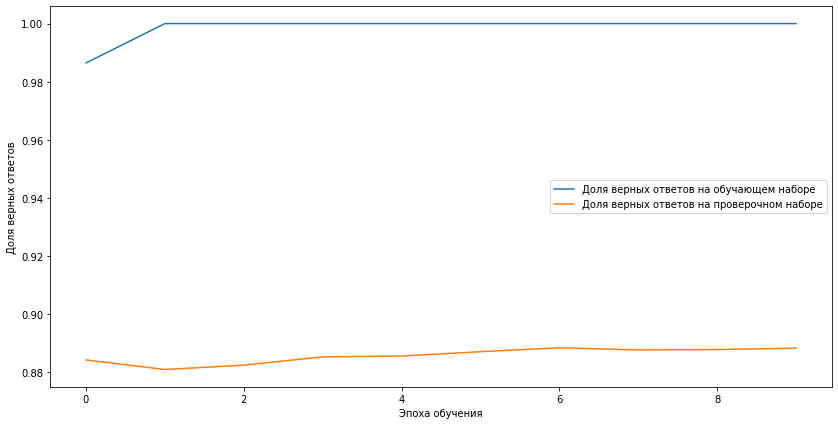

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
#Проверяем точность нейронки обученной на bag of words
pred = recognizeMultiClass(model01, xTest6Classes01, "Тексты 01 + Dense")

НЕЙРОНКА:  Тексты 01 + Dense

Класс: О. Генри   95% сеть отнесла к классу О. Генри   Это ПРАВИЛЬНЫЙ ответ!
Класс: Стругацкие 84% сеть отнесла к классу Стругацкие Это ПРАВИЛЬНЫЙ ответ!
Класс: Булгаков   80% сеть отнесла к классу Булгаков   Это ПРАВИЛЬНЫЙ ответ!
Класс: Саймак     80% сеть отнесла к классу Саймак     Это ПРАВИЛЬНЫЙ ответ!
Класс: Фрай       90% сеть отнесла к классу Фрай       Это ПРАВИЛЬНЫЙ ответ!
Класс: Брэдберри  97% сеть отнесла к классу Брэдберри  Это ПРАВИЛЬНЫЙ ответ!

Средний процент распознавания 88%



#### BagOfWords + softmax

In [ ]:
#Создаём полносвязную сеть
model02 = Sequential()
#Первый полносвязный слой
model02.add(Dense(200, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model02.add(Dropout(0.25))
#Слой пакетной нормализации
model02.add(BatchNormalization())
#Выходной полносвязный слой
model02.add(Dense(6, activation='softmax'))

model02.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model02.fit(xTrain01, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))

Epoch 1/10
138/138 [==============================] - 2s 15ms/step - loss: 0.0479 - accuracy: 0.9854 - val_loss: 0.4119 - val_accuracy: 0.8658
Epoch 2/10
138/138 [==============================] - 2s 11ms/step - loss: 3.2737e-04 - accuracy: 1.0000 - val_loss: 0.3639 - val_accuracy: 0.8714
Epoch 3/10
138/138 [==============================] - 2s 11ms/step - loss: 1.6312e-04 - accuracy: 1.0000 - val_loss: 0.3564 - val_accuracy: 0.8715
Epoch 4/10
138/138 [==============================] - 2s 12ms/step - loss: 1.0283e-04 - accuracy: 1.0000 - val_loss: 0.3529 - val_accuracy: 0.8735
Epoch 5/10
138/138 [==============================] - 2s 11ms/step - loss: 7.2478e-05 - accuracy: 1.0000 - val_loss: 0.3492 - val_accuracy: 0.8738
Epoch 6/10
138/138 [==============================] - 2s 12ms/step - loss: 5.7708e-05 - accuracy: 1.0000 - val_loss: 0.3495 - val_accuracy: 0.8745
Epoch 7/10
138/138 [==============================] - 2s 11ms/step - loss: 4.6874e-05 - accuracy: 1.0000 - val_loss: 0.354

In [ ]:
model02.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 200)               4000200   
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 1206      
Total params: 4,002,206
Trainable params: 4,001,806
Non-trainable params: 400
_________________________________________________________________


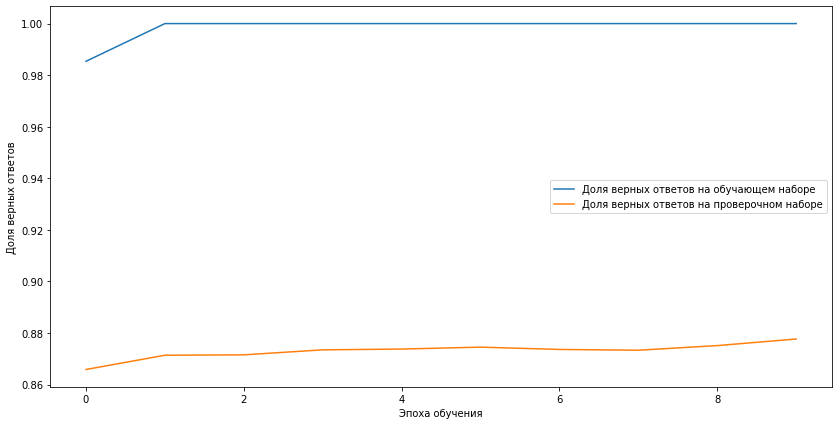

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
model02.compile(optimizer=Adam(0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history2 = model02.fit(xTrain01, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))

Epoch 1/10
138/138 [==============================] - 3s 15ms/step - loss: 1.7065e-05 - accuracy: 1.0000 - val_loss: 0.3362 - val_accuracy: 0.8784
Epoch 2/10
138/138 [==============================] - 2s 11ms/step - loss: 7.2633e-06 - accuracy: 1.0000 - val_loss: 0.3301 - val_accuracy: 0.8793
Epoch 3/10
138/138 [==============================] - 2s 12ms/step - loss: 4.3644e-06 - accuracy: 1.0000 - val_loss: 0.3276 - val_accuracy: 0.8803
Epoch 4/10
138/138 [==============================] - 2s 12ms/step - loss: 2.7831e-06 - accuracy: 1.0000 - val_loss: 0.3224 - val_accuracy: 0.8815
Epoch 5/10
138/138 [==============================] - 2s 12ms/step - loss: 1.9616e-06 - accuracy: 1.0000 - val_loss: 0.3235 - val_accuracy: 0.8838
Epoch 6/10
138/138 [==============================] - 2s 11ms/step - loss: 1.4535e-06 - accuracy: 1.0000 - val_loss: 0.3229 - val_accuracy: 0.8839
Epoch 7/10
138/138 [==============================] - 2s 11ms/step - loss: 1.3133e-06 - accuracy: 1.0000 - val_loss: 0

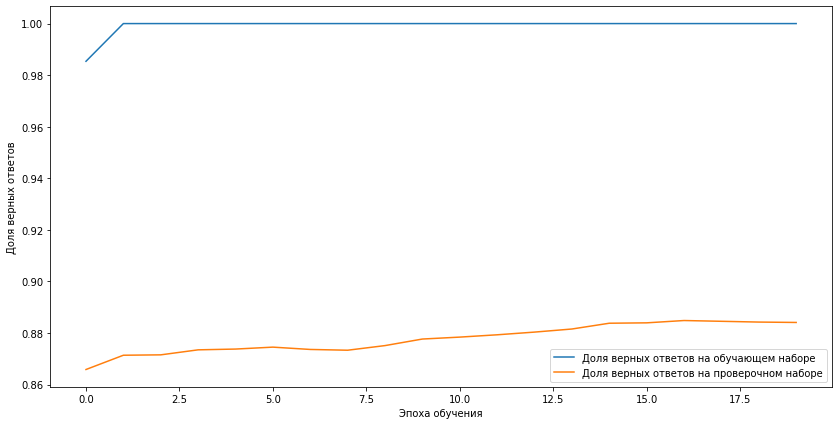

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['accuracy'] + history2.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'] + history2.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
#Проверяем точность нейронки обученной на bag of words
pred = recognizeMultiClass(model02, xTest6Classes01, "Тексты 01 + Dense")

НЕЙРОНКА:  Тексты 01 + Dense

Класс: О. Генри   93% сеть отнесла к классу О. Генри   Это ПРАВИЛЬНЫЙ ответ!
Класс: Стругацкие 84% сеть отнесла к классу Стругацкие Это ПРАВИЛЬНЫЙ ответ!
Класс: Булгаков   76% сеть отнесла к классу Булгаков   Это ПРАВИЛЬНЫЙ ответ!
Класс: Саймак     79% сеть отнесла к классу Саймак     Это ПРАВИЛЬНЫЙ ответ!
Класс: Фрай       92% сеть отнесла к классу Фрай       Это ПРАВИЛЬНЫЙ ответ!
Класс: Брэдберри  99% сеть отнесла к классу Брэдберри  Это ПРАВИЛЬНЫЙ ответ!

Средний процент распознавания 88%



#### Embedding + Dense


In [ ]:
#Создаём сеть с Embedding слоем
model03 = Sequential()
model03.add(Embedding(maxWordsCount, 20, input_length=xLen))
model03.add(SpatialDropout1D(0.2))
model03.add(Flatten())
model03.add(BatchNormalization())
model03.add(Dense(200, activation="relu"))
model03.add(Dropout(0.2))
model03.add(BatchNormalization())
model03.add(Dense(6, activation='softmax'))

model03.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model03.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 20)          400000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 1000, 20)          0         
_________________________________________________________________
flatten (Flatten)            (None, 20000)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20000)             80000     
_________________________________________________________________
dense (Dense)                (None, 200)               4000200   
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               8

In [ ]:
#Обучаем сеть на xTrain
history = model03.fit(xTrain, 
                    yTrain, 
                    epochs=10,
                    batch_size=128,
                    validation_data=(xTest, yTest))

Epoch 1/10
138/138 [==============================] - 8s 37ms/step - loss: 0.8445 - accuracy: 0.7356 - val_loss: 1.6617 - val_accuracy: 0.4210
Epoch 2/10
138/138 [==============================] - 5s 35ms/step - loss: 0.0153 - accuracy: 0.9991 - val_loss: 1.4263 - val_accuracy: 0.4215
Epoch 3/10
138/138 [==============================] - 5s 35ms/step - loss: 0.0070 - accuracy: 0.9997 - val_loss: 1.1723 - val_accuracy: 0.5636
Epoch 4/10
138/138 [==============================] - 5s 34ms/step - loss: 0.0043 - accuracy: 0.9997 - val_loss: 0.9930 - val_accuracy: 0.6360
Epoch 5/10
138/138 [==============================] - 5s 35ms/step - loss: 0.0032 - accuracy: 0.9997 - val_loss: 0.8898 - val_accuracy: 0.6769
Epoch 6/10
138/138 [==============================] - 5s 34ms/step - loss: 0.0023 - accuracy: 0.9999 - val_loss: 0.9061 - val_accuracy: 0.6885
Epoch 7/10
138/138 [==============================] - 5s 35ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.8936 - val_accuracy: 0.6917

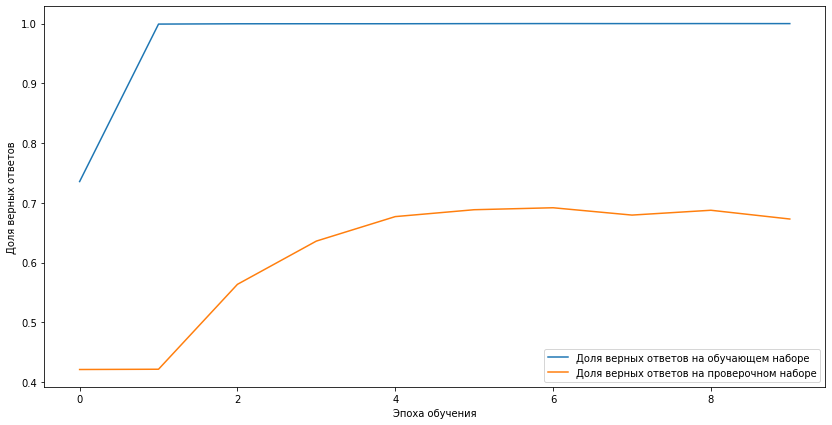

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
model03.save_weights('model.h5')

In [ ]:
model03.load_weights('model.h5')

In [ ]:
#Проверяем результаты работы Ebedding сети
_, xTest6Classes = createTestMultiClasses(testWordIndexes, xLen, step) #Преобразование тестовой выборки
pred = recognizeMultiClass(model03, xTest6Classes, "Embedding + Dense")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


НЕЙРОНКА:  Embedding + Dense

Класс: О. Генри   70% сеть отнесла к классу О. Генри   Это ПРАВИЛЬНЫЙ ответ!
Класс: Стругацкие 70% сеть отнесла к классу Стругацкие Это ПРАВИЛЬНЫЙ ответ!
Класс: Булгаков   45% сеть отнесла к классу Булгаков   Это ПРАВИЛЬНЫЙ ответ!
Класс: Саймак     69% сеть отнесла к классу Саймак     Это ПРАВИЛЬНЫЙ ответ!
Класс: Фрай       83% сеть отнесла к классу Фрай       Это ПРАВИЛЬНЫЙ ответ!
Класс: Брэдберри  60% сеть отнесла к классу Брэдберри  Это ПРАВИЛЬНЫЙ ответ!

Средний процент распознавания 67%



**output_dim = 200**

In [ ]:
#Создаём сеть с Embedding слоем
modelE = Sequential()
modelE.add(Embedding(maxWordsCount, 200, input_length=xLen))
modelE.add(SpatialDropout1D(0.2))
modelE.add(Flatten())
modelE.add(BatchNormalization())
modelE.add(Dense(200, activation="relu"))
modelE.add(Dropout(0.2))
modelE.add(BatchNormalization())
modelE.add(Dense(6, activation='sigmoid'))

modelE.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
modelE.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 200)         4000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 1000, 200)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 200000)            0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 200000)            800000    
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40000200  
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 200)              

In [ ]:
#Обучаем сеть на xTrain
history = modelE.fit(xTrain, 
                    yTrain, 
                    epochs=10,
                    batch_size=128,
                    validation_data=(xTest, yTest))

Epoch 1/10
138/138 [==============================] - 31s 219ms/step - loss: 0.6183 - accuracy: 0.8342 - val_loss: 1.6701 - val_accuracy: 0.3600
Epoch 2/10
138/138 [==============================] - 29s 210ms/step - loss: 0.0096 - accuracy: 0.9999 - val_loss: 1.4517 - val_accuracy: 0.3926
Epoch 3/10
138/138 [==============================] - 29s 208ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.1152 - val_accuracy: 0.5827
Epoch 4/10
138/138 [==============================] - 29s 208ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.8933 - val_accuracy: 0.6904
Epoch 5/10
138/138 [==============================] - 28s 207ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.8120 - val_accuracy: 0.7203
Epoch 6/10
138/138 [==============================] - 29s 208ms/step - loss: 7.9748e-04 - accuracy: 1.0000 - val_loss: 0.8024 - val_accuracy: 0.7288
Epoch 7/10
138/138 [==============================] - 29s 207ms/step - loss: 5.8315e-04 - accuracy: 1.0000 - val_loss: 0.8045 

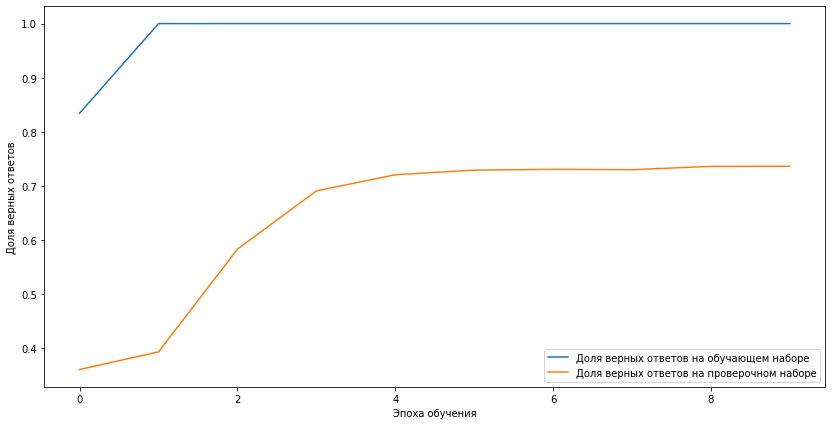

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
#Проверяем результаты работы Ebedding сети
_, xTest6Classes = createTestMultiClasses(testWordIndexes, xLen, step) #Преобразование тестовой выборки
pred = recognizeMultiClass(modelE, xTest6Classes, "Embedding + Dense")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


НЕЙРОНКА:  Embedding + Dense

Класс: О. Генри   84% сеть отнесла к классу О. Генри   Это ПРАВИЛЬНЫЙ ответ!
Класс: Стругацкие 68% сеть отнесла к классу Стругацкие Это ПРАВИЛЬНЫЙ ответ!
Класс: Булгаков   62% сеть отнесла к классу Булгаков   Это ПРАВИЛЬНЫЙ ответ!
Класс: Саймак     76% сеть отнесла к классу Саймак     Это ПРАВИЛЬНЫЙ ответ!
Класс: Фрай       84% сеть отнесла к классу Фрай       Это ПРАВИЛЬНЫЙ ответ!
Класс: Брэдберри  68% сеть отнесла к классу Брэдберри  Это ПРАВИЛЬНЫЙ ответ!

Средний процент распознавания 73%



In [ ]:
#Создаём сеть с Embedding слоем
modelE = Sequential()
modelE.add(Embedding(maxWordsCount, 200, input_length=xLen))
modelE.add(Flatten())
modelE.add(BatchNormalization())
modelE.add(Dense(200, activation="relu"))
modelE.add(BatchNormalization())
modelE.add(Dense(6, activation='sigmoid'))

modelE.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
modelE.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 200)         4000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 200000)            0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 200000)            800000    
_________________________________________________________________
dense_4 (Dense)              (None, 200)               40000200  
_________________________________________________________________
batch_normalization_5 (Batch (None, 200)               800       
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 1206      
Total params: 44,802,206
Trainable params: 44,401,806
Non-trainable params: 400,400
____________________________________

In [ ]:
#Обучаем сеть на xTrain
history = modelE.fit(xTrain, 
                    yTrain, 
                    epochs=10,
                    batch_size=128,
                    validation_data=(xTest, yTest))

Epoch 1/10
138/138 [==============================] - 29s 205ms/step - loss: 0.5672 - accuracy: 0.8618 - val_loss: 1.6830 - val_accuracy: 0.3492
Epoch 2/10
138/138 [==============================] - 28s 205ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 1.4117 - val_accuracy: 0.4635
Epoch 3/10
138/138 [==============================] - 29s 207ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.1394 - val_accuracy: 0.5758
Epoch 4/10
138/138 [==============================] - 28s 205ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.9399 - val_accuracy: 0.6623
Epoch 5/10
138/138 [==============================] - 28s 206ms/step - loss: 7.4260e-04 - accuracy: 1.0000 - val_loss: 0.8850 - val_accuracy: 0.6928
Epoch 6/10
138/138 [==============================] - 28s 203ms/step - loss: 5.1537e-04 - accuracy: 1.0000 - val_loss: 0.8760 - val_accuracy: 0.7080
Epoch 7/10
138/138 [==============================] - 29s 208ms/step - loss: 3.7386e-04 - accuracy: 1.0000 - val_loss: 0.8

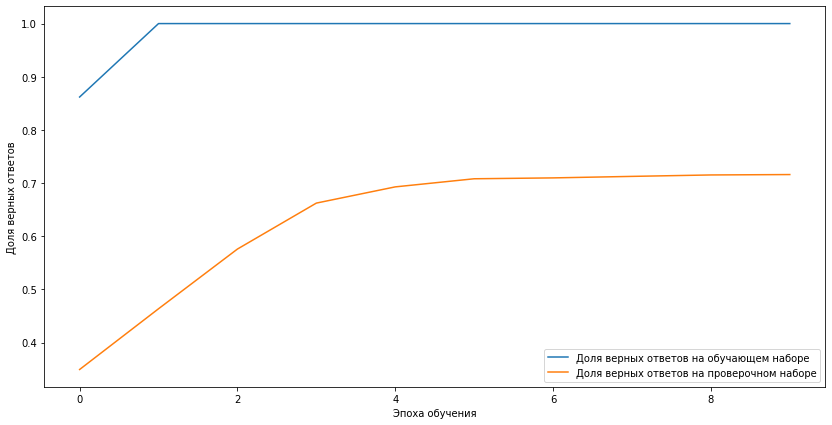

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
#Проверяем результаты работы Ebedding сети
_, xTest6Classes = createTestMultiClasses(testWordIndexes, xLen, step) #Преобразование тестовой выборки
pred = recognizeMultiClass(modelE, xTest6Classes, "Embedding + Dense")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


НЕЙРОНКА:  Embedding + Dense

Класс: О. Генри   81% сеть отнесла к классу О. Генри   Это ПРАВИЛЬНЫЙ ответ!
Класс: Стругацкие 75% сеть отнесла к классу Стругацкие Это ПРАВИЛЬНЫЙ ответ!
Класс: Булгаков   53% сеть отнесла к классу Булгаков   Это ПРАВИЛЬНЫЙ ответ!
Класс: Саймак     64% сеть отнесла к классу Саймак     Это ПРАВИЛЬНЫЙ ответ!
Класс: Фрай       79% сеть отнесла к классу Фрай       Это ПРАВИЛЬНЫЙ ответ!
Класс: Брэдберри  74% сеть отнесла к классу Брэдберри  Это ПРАВИЛЬНЫЙ ответ!

Средний процент распознавания 71%



# Классификация текстов на базе обращений граждан


**Загрузка данных**


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Базы/clean_data.csv') #загружаем данные в dataframe
df = df.iloc[:, :2] #извлечём тексты обращений и соответствующие им категории
df.head(10)    #посмотрим на содержимое

,text,category
0,Здравствуйте. Подскажите пожалуйста можно ли с...,Дороги и транспорт
1,Подскажите пожалуйста имеют ли право не платит...,ЖКХ
2,""" Спасибо Вам огромное за возобновление строит...",Строительство
3,Проблема одна и общая стала в городе. Спорт. у...,Спорт
4,Некоторое время назад для школьников и студент...,Дороги и транспорт
5,"Доброго времени суток! Надеюсь, мое сообщение ...",Дороги и транспорт
6,хочу предложить вот что у нас в городе потихон...,Дороги и транспорт
7,"Добрый вечер. Хотелось бы, чтобы обратили вним...",Дороги и транспорт
8,"Здравствуйте, больше 9 месяцев я и жильцы микр...",Благо­­устрой­­ство
9,На улице Кирова (это центр города!!!!) отсутст...,Дороги и транспорт


In [ ]:
print(df.shape) #Выведем форму таблицы

(10059, 2)


In [ ]:
print(df.values[0]) #Выведем пример из таблицы 

['Здравствуйте. Подскажите пожалуйста можно ли сделать проезд для школьников по льготной цене. Для людей работающих в бюджетной организации, с детьми на проезд уходит значительная часть денег на оплату проезда .'
 'Дороги и транспорт']


**Обучение без фильтрации данных**


In [ ]:
for cl in df['category'].unique(): #Проходим по всем классам
  print('Количество записей класса ', cl, ': ', df[df.category == cl].shape[0])
  

Количество записей класса  Дороги и транспорт :  1411
Количество записей класса  ЖКХ :  2063
Количество записей класса  Строительство :  349
Количество записей класса  Спорт :  246
Количество записей класса  Благо­­устрой­­ство :  1686
Количество записей класса  Образование и наука :  290
Количество записей класса  Культура :  100
Количество записей класса  Демография :  20
Количество записей класса  Социальная сфера :  370
Количество записей класса  Другое :  208
Количество записей класса  Бизнес :  187
Количество записей класса  Здравоохранение :  368
Количество записей класса  Органы власти :  244
Количество записей класса  Экология :  180
Количество записей класса  Правопорядок :  172
Количество записей класса  Труд и занятость населения :  151
Количество записей класса  Борьба с коррупцией :  59
Количество записей класса  Промышленность :  13
Количество записей класса  Сельское хозяйство :  50
Количество записей класса  Земельные отношения :  80
Количество записей класса  Туризм :

In [ ]:
texts = df['text'].values #Извлекаем данные всех текстов из столбца text
classes = list(df['category'].values) #Извлекаем соответствующие им значения классов (лейблов) столбца text
maxWordsCount = 60000 #Зададим максимальное количество слов/индексов, учитываемое при обучении текстов

print(df['category'].unique()) #Выводим все уникальные значения классов
nClasses = df['category'].nunique()+1  #Задаём количество классов, обращаясь к столбцу category и оставляя уникальные значения
print(nClasses) #Посмотрим на количество классов

['Дороги и транспорт' 'ЖКХ' 'Строительство' 'Спорт'
 'Благо\xad\xadустрой\xad\xadство' 'Образование и наука' 'Культура'
 'Демография' 'Социальная сфера' 'Другое' 'Бизнес' 'Здравоохранение'
 'Органы власти' 'Экология' 'Правопорядок' 'Труд и занятость населения'
 'Борьба с коррупцией' 'Промышленность' 'Сельское хозяйство'
 'Земельные отношения' 'Туризм' nan]
22


In [ ]:
#Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью
#Для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
#num_words=maxWordsCount - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
#filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' - избавляемся от ненужных символов
#lower=True - приводим слова к нижнему регистру
#split=' ' - разделяем слова по пробелу
#char_level=False - просим токенайзер не удалять однобуквенные слова
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(texts) #"Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности

#Формируем матрицу индексов по принципу Bag of Words
xAll = tokenizer.texts_to_matrix(texts) #Каждое слово из текста нашло свой индекс в векторе длиной maxWordsCount и отметилось в нем единичкой 
print(xAll.shape)  #Посмотрим на форму текстов
print(xAll[0, :20])#И отдельно на фрагмент начала вектора

(10059, 60000)
[0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [ ]:
print(tokenizer.word_index.items()) #Вытаскиваем индексы слов для просмотра

dict_items([('unknown', 1), ('в', 2), ('и', 3), ('на', 4), ('не', 5), ('с', 6), ('по', 7), ('что', 8), ('а', 9), ('к', 10), ('за', 11), ('я', 12), ('но', 13), ('как', 14), ('для', 15), ('от', 16), ('у', 17), ('это', 18), ('мы', 19), ('так', 20), ('все', 21), ('дома', 22), ('из', 23), ('нет', 24), ('то', 25), ('о', 26), ('до', 27), ('года', 28), ('очень', 29), ('нас', 30), ('ул', 31), ('уже', 32), ('г', 33), ('прошу', 34), ('№', 35), ('области', 36), ('нам', 37), ('только', 38), ('было', 39), ('же', 40), ('мне', 41), ('день', 42), ('бы', 43), ('вам', 44), ('лет', 45), ('при', 46), ('липецкой', 47), ('время', 48), ('ни', 49), ('здравствуйте', 50), ('меня', 51), ('города', 52), ('т', 53), ('дом', 54), ('есть', 55), ('вас', 56), ('они', 57), ('если', 58), ('или', 59), ('д', 60), ('после', 61), ('детей', 62), ('будет', 63), ('которые', 64), ('во', 65), ('чтобы', 66), ('без', 67), ('их', 68), ('где', 69), ('там', 70), ('улице', 71), ('когда', 72), ('этом', 73), ('добрый', 74), ('был', 75), (

In [ ]:
print("Размер словаря", len(tokenizer.word_index.items()))

Размер словаря 80594


In [ ]:
#Преобразовываем категории в векторы
encoder = LabelEncoder() # Вызываем метод кодирования тестовых лейблов из библиотеки sklearn
encoder.fit(classes) # Подгружаем в него категории из нашей базы
classesEncoded = encoder.transform(classes) # Кодируем категории
print(encoder.classes_)
print(classesEncoded.shape)
print(classesEncoded[:10])

['nan' 'Бизнес' 'Благо\xad\xadустрой\xad\xadство' 'Борьба с коррупцией'
 'Демография' 'Дороги и транспорт' 'Другое' 'ЖКХ' 'Здравоохранение'
 'Земельные отношения' 'Культура' 'Образование и наука' 'Органы власти'
 'Правопорядок' 'Промышленность' 'Сельское хозяйство' 'Социальная сфера'
 'Спорт' 'Строительство' 'Труд и занятость населения' 'Туризм' 'Экология']
(10059,)
[ 5  7 18 17  5  5  5  5  2  5]


In [ ]:
yAll = utils.to_categorical(classesEncoded, nClasses) # И выводим каждый лейбл в виде вектора длиной 22, с 1кой в позиции соответствующего класса и нулями
print(yAll.shape) # Посмотрим на форму лейблов категорий
print(yAll[0]) # И отдельно на первую строку

(10059, 22)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


**Создание обучающей и проверочной выборки**



In [ ]:
# разбиваем все данные на обучающую и тестовую выборки с помощью метода train_test_split из библиотеки sklearn
xTrain, xVal, yTrain, yVal = train_test_split(xAll, yAll, test_size=0.2, shuffle = True)
print(xTrain.shape) #посмотрим на форму текстов из обучающей выборки
print(yTrain.shape) #и на форму соответсвующих им классов

(8047, 60000)
(8047, 22)


In [ ]:
# для Эмбэддинга представляем текст в виде последовательности индексов слов, каждый из которых затем преобразуем в многомерный вектор
Sequences = tokenizer.texts_to_sequences(texts) #разбиваем текст на последовательность индексов
npSequences = np.array(Sequences)                #переведём в массив numpy
xTrainE, xValE, yTrainE, yValE = train_test_split(npSequences, yAll, test_size=0.2)#сформируем новую форму выборки
print(xTrainE.shape) #посмотрим на форму текстов из обучающей выборки
print(yTrainE.shape)  #и на форму соответствующих им классов

(8047,)
(8047, 22)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


**Нейросеть**


BagOfWords + Dense

Epoch 1/20
63/63 [==============================] - 5s 38ms/step - loss: 2.4504 - accuracy: 0.2464 - val_loss: 1.9338 - val_accuracy: 0.4389
Epoch 2/20
63/63 [==============================] - 2s 27ms/step - loss: 1.8033 - accuracy: 0.4302 - val_loss: 1.7259 - val_accuracy: 0.4697
Epoch 3/20
63/63 [==============================] - 2s 27ms/step - loss: 1.4027 - accuracy: 0.5586 - val_loss: 1.6461 - val_accuracy: 0.5109
Epoch 4/20
63/63 [==============================] - 2s 27ms/step - loss: 1.0861 - accuracy: 0.6703 - val_loss: 1.6855 - val_accuracy: 0.5363
Epoch 5/20
63/63 [==============================] - 2s 27ms/step - loss: 0.8418 - accuracy: 0.7496 - val_loss: 1.7605 - val_accuracy: 0.5383
Epoch 6/20
63/63 [==============================] - 2s 27ms/step - loss: 0.6699 - accuracy: 0.7992 - val_loss: 1.8776 - val_accuracy: 0.5512
Epoch 7/20
63/63 [==============================] - 2s 29ms/step - loss: 0.5568 - accuracy: 0.8377 - val_loss: 1.9291 - val_accuracy: 0.5492
Epoch 8/20
63

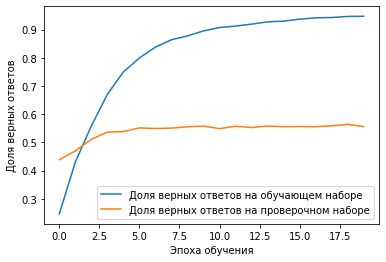

In [ ]:
#Создаём полносвязную сеть
model01 = Sequential()
#Входной полносвязный слой
model01.add(Dense(100, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model01.add(Dropout(0.4))
#Второй полносвязный слой
model01.add(Dense(100, activation='relu'))
#Слой регуляризации Dropout
model01.add(Dropout(0.4))
#Третий полносвязный слой
model01.add(Dense(100, activation='relu'))
#Слой регуляризации Dropout
model01.add(Dropout(0.4))
#Выходной полносвязный слой
model01.add(Dense(nClasses, activation='softmax'))


model01.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке
history = model01.fit(xTrain, 
                    yTrain, 
                    epochs=20,
                    batch_size=128,
                    validation_data=(xVal, yVal))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

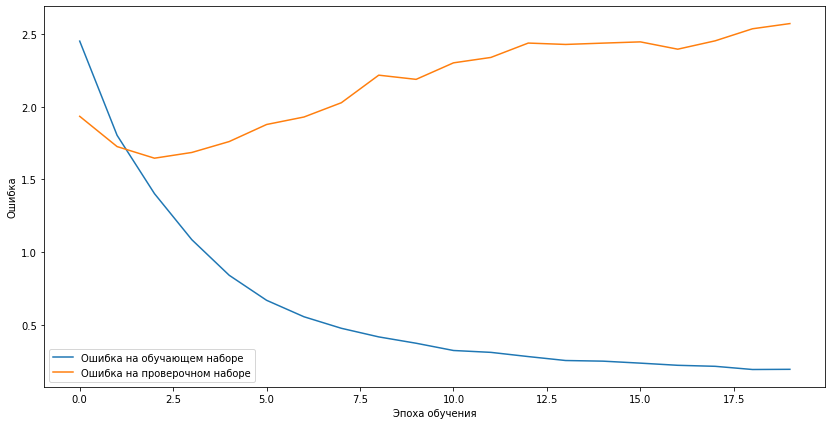

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

**Embedding + Dense**



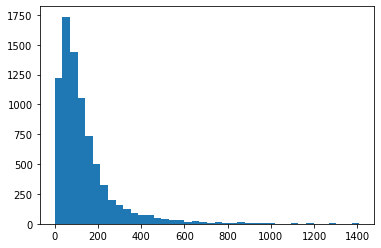

In [ ]:
lenXTrainE = [len(x) for x in xTrainE]
plt.hist(lenXTrainE, 40)
plt.show()

In [ ]:
maxlen = 400
xTrainE = pad_sequences(xTrainE, maxlen=maxlen) #Преобразуем входные векторы
xValE = pad_sequences(xValE, maxlen=maxlen) #Преобразуем входные векторы

In [ ]:
print(xTrainE.shape)

(8047, 400)


Epoch 1/15
161/161 [==============================] - 10s 43ms/step - loss: 3.0916 - accuracy: 0.1495 - val_loss: 2.5446 - val_accuracy: 0.1884
Epoch 2/15
161/161 [==============================] - 6s 40ms/step - loss: 1.6915 - accuracy: 0.5221 - val_loss: 2.3128 - val_accuracy: 0.1854
Epoch 3/15
161/161 [==============================] - 6s 40ms/step - loss: 0.6200 - accuracy: 0.8470 - val_loss: 2.0799 - val_accuracy: 0.3434
Epoch 4/15
161/161 [==============================] - 7s 41ms/step - loss: 0.2567 - accuracy: 0.9494 - val_loss: 1.9831 - val_accuracy: 0.4175
Epoch 5/15
161/161 [==============================] - 7s 41ms/step - loss: 0.1319 - accuracy: 0.9797 - val_loss: 2.0410 - val_accuracy: 0.4230
Epoch 6/15
161/161 [==============================] - 6s 39ms/step - loss: 0.0863 - accuracy: 0.9881 - val_loss: 2.1145 - val_accuracy: 0.4225
Epoch 7/15
161/161 [==============================] - 7s 41ms/step - loss: 0.0613 - accuracy: 0.9902 - val_loss: 2.1726 - val_accuracy: 0.415

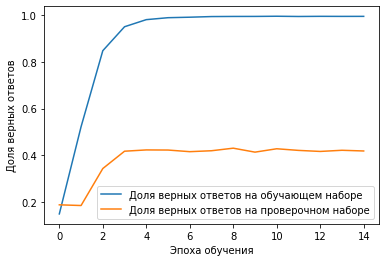

In [ ]:
#Создаём полносвязную сеть
modelE = Sequential()
#Cлой представления всего словаря слов в векторном представлении
modelE.add(Embedding(maxWordsCount, 50, input_length=maxlen))
#Слой регуляризации Dropout
modelE.add(SpatialDropout1D(0.2))
#Cлой преобразования двумерных данных в одномерные
modelE.add(Flatten())
#Слой пакетной нормализации
modelE.add(BatchNormalization())
#Полносвязный слой
modelE.add(Dense(64, activation="relu"))
#Слой регуляризации Dropout
modelE.add(Dropout(0.2))
#Слой пакетной нормализации
modelE.add(BatchNormalization())
#Выходной полносвязный слой
modelE.add(Dense(nClasses, activation='softmax'))

modelE.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на xTrain
history = modelE.fit(xTrainE, 
                    yTrainE, 
                    epochs=15,
                    batch_size=50,
                    validation_data=(xValE, yValE))


plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

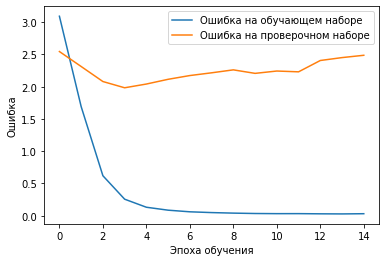

In [ ]:
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

**Подготовка данных**



In [ ]:
#Обрабатываем выборку

maxCountStrings = 400 #Задаем максимальное число строк для классов
minCountStrings = 300 #Задаем минимальное число строк для классов
df = df.dropna().reset_index() #Удаляем пустые значения и обновляем индексы в таблице

for cl in df['category'].unique(): #Проходим по всем классам
  initialLen = df[df.category == cl].shape[0]
  if(df[df.category == cl].shape[0] < minCountStrings): #Если в классе количество строк меньше minCountStrings
    df = df.drop(df[df.category == cl].index) #Удаляем данный класс
  if(df[df.category == cl].shape[0] > maxCountStrings): #Если в классе количество строк больше maxCountStrings
    df = df.drop(df[df.category == cl].index[maxCountStrings:]) #Оставляем в таблице строки количеством maxCountStrings
  print('Количество записей класса ', cl, ': ', initialLen, '. В выборку вошло: ', df[df.category == cl].shape[0], sep='')
  
df = df.reset_index() #Обновляем индексы в таблице

Количество записей класса Дороги и транспорт: 1411. В выборку вошло: 400
Количество записей класса ЖКХ: 2063. В выборку вошло: 400
Количество записей класса Строительство: 349. В выборку вошло: 349
Количество записей класса Спорт: 246. В выборку вошло: 0
Количество записей класса Благо­­устрой­­ство: 1686. В выборку вошло: 400
Количество записей класса Образование и наука: 290. В выборку вошло: 0
Количество записей класса Культура: 100. В выборку вошло: 0
Количество записей класса Демография: 20. В выборку вошло: 0
Количество записей класса Социальная сфера: 370. В выборку вошло: 370
Количество записей класса Другое: 208. В выборку вошло: 0
Количество записей класса Бизнес: 187. В выборку вошло: 0
Количество записей класса Здравоохранение: 368. В выборку вошло: 368
Количество записей класса Органы власти: 244. В выборку вошло: 0
Количество записей класса Экология: 180. В выборку вошло: 0
Количество записей класса Правопорядок: 172. В выборку вошло: 0
Количество записей класса Труд и за

In [ ]:
texts = df['text'].values #Извлекаем данные всех текстов из столбца text
classes = list(df['category'].values) #Извлекаем соответствующие им значения классов(лейблов) столбца text
maxWordsCount = 60000 #Зададим макс.кол-во слов/индексов, учитываемое при обучении текстов

print(df['category'].unique()) #Выводим все уникальные значения классов
nClasses = df['category'].nunique()+1  #Задаём количество классов, обращаясь к столбцу category и оставляя уникальные значения
print(nClasses) #Посмотрим на количество классов

['Дороги и транспорт' 'ЖКХ' 'Строительство'
 'Благо\xad\xadустрой\xad\xadство' 'Социальная сфера' 'Здравоохранение']
7


In [ ]:
#Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью
#Для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
#num_words=maxWordsCount - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
#filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' - избавляемся от ненужных символов
#lower=True - приводим слова к нижнему регистру
#split=' ' - разделяем слова по пробелу
#char_level=False - просим токенайзер не удалять однобуквенные слова
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(texts) #"Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности

#Формируем матрицу индексов по принципу Bag of Words
xAll = tokenizer.texts_to_matrix(texts) #Каждое слово из текста нашло свой индекс в векторе длиной maxWordsCount и отметилось в нем единичкой 
print(xAll.shape)  #Посмотрим на форму текстов
print(xAll[0, :20])#И отдельно на фрагмент начала вектора

(2287, 60000)
[0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [ ]:
print(tokenizer.word_index.items()) #Вытаскиваем индексы слов для просмотра

dict_items([('unknown', 1), ('в', 2), ('и', 3), ('на', 4), ('не', 5), ('с', 6), ('по', 7), ('что', 8), ('а', 9), ('к', 10), ('я', 11), ('за', 12), ('но', 13), ('как', 14), ('у', 15), ('мы', 16), ('для', 17), ('от', 18), ('это', 19), ('так', 20), ('нет', 21), ('дома', 22), ('то', 23), ('все', 24), ('из', 25), ('о', 26), ('до', 27), ('нас', 28), ('года', 29), ('очень', 30), ('г', 31), ('уже', 32), ('нам', 33), ('№', 34), ('ул', 35), ('мне', 36), ('области', 37), ('прошу', 38), ('лет', 39), ('только', 40), ('было', 41), ('же', 42), ('дом', 43), ('время', 44), ('бы', 45), ('липецкой', 46), ('день', 47), ('города', 48), ('при', 49), ('вам', 50), ('меня', 51), ('если', 52), ('ни', 53), ('вас', 54), ('или', 55), ('здравствуйте', 56), ('детей', 57), ('2018', 58), ('есть', 59), ('будет', 60), ('т', 61), ('когда', 62), ('году', 63), ('после', 64), ('чтобы', 65), ('этом', 66), ('без', 67), ('д', 68), ('они', 69), ('улице', 70), ('где', 71), ('там', 72), ('липецка', 73), ('его', 74), ('спасибо', 7

In [ ]:
print("Размер словаря", len(tokenizer.word_index.items()))

Размер словаря 35782


In [ ]:
#Преобразовываем категории в векторы
encoder = LabelEncoder() #Вызываем метод кодирования тестовых лейблов из библиотеки sklearn
encoder.fit(classes) #Подгружаем в него категории из нашей базы
classesEncoded = encoder.transform(classes) #Кодируем категории
yAll = utils.to_categorical(classesEncoded, nClasses) #И выводим каждый лейбл в виде вектора длиной 22, с 1кой в позиции соответсвующего класса и нулями
print(yAll.shape) #Посмотрим на форму лейблов категорий
print(yAll[0]) #И отдельно на первую строку

(2287, 7)
[0. 1. 0. 0. 0. 0. 0.]


**Создание обучающей и проверочной выборки**


In [ ]:
# разбиваем все данные на обучающую и тестовую выборки с помощью метода train_test_split из библиотеки sklearn
xTrain, xVal, yTrain, yVal = train_test_split(xAll, yAll, test_size=0.2, shuffle=True)
print(xTrain.shape) #посмотрим на форму текстов из обучающей выборки
print(yTrain.shape) #и на форму соответсвующих им классов

(1829, 60000)
(1829, 7)


In [ ]:
# для Эмбэддинга представляем текст в виде последовательности индексов слов, каждый из которых затем преобразуем в многомерный вектор
Sequences = tokenizer.texts_to_sequences(texts) #разбиваем текст на последовательность индексов
npSequences = np.array(Sequences)                #переведём в массив numpy
xTrainE, xValE, yTrainE, yValE = train_test_split(npSequences, yAll, test_size=0.2)#сформируем новую форму выборки
print(xTrainE.shape) #взглянем на форму текстов из обучающей выборки
print(yTrain.shape)  #и на форму соответствующих им классов

(1829,)
(1829, 7)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


**Нейросеть**


BagOfWords + Dense

Epoch 1/20
15/15 [==============================] - 1s 45ms/step - loss: 1.7261 - accuracy: 0.3794 - val_loss: 1.4130 - val_accuracy: 0.7249
Epoch 2/20
15/15 [==============================] - 0s 30ms/step - loss: 1.0237 - accuracy: 0.8442 - val_loss: 1.0519 - val_accuracy: 0.7904
Epoch 3/20
15/15 [==============================] - 0s 29ms/step - loss: 0.6146 - accuracy: 0.9278 - val_loss: 0.8825 - val_accuracy: 0.8035
Epoch 4/20
15/15 [==============================] - 0s 30ms/step - loss: 0.4051 - accuracy: 0.9574 - val_loss: 0.8029 - val_accuracy: 0.7860
Epoch 5/20
15/15 [==============================] - 0s 28ms/step - loss: 0.2829 - accuracy: 0.9770 - val_loss: 0.7546 - val_accuracy: 0.7991
Epoch 6/20
15/15 [==============================] - 0s 28ms/step - loss: 0.2050 - accuracy: 0.9896 - val_loss: 0.7331 - val_accuracy: 0.7926
Epoch 7/20
15/15 [==============================] - 0s 30ms/step - loss: 0.1581 - accuracy: 0.9918 - val_loss: 0.7182 - val_accuracy: 0.7969
Epoch 8/20
15

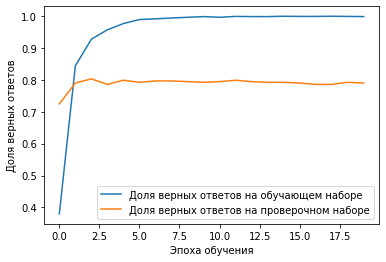

In [ ]:
#Создаём полносвязную сеть
model01 = Sequential()
#Входной полносвязный слой
model01.add(Dense(64, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model01.add(Dropout(0.4))
model01.add(Dense(nClasses, activation='softmax'))

model01.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке
history = model01.fit(xTrain, 
                    yTrain, 
                    epochs=20,
                    batch_size=128,
                    validation_data=(xVal, yVal))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

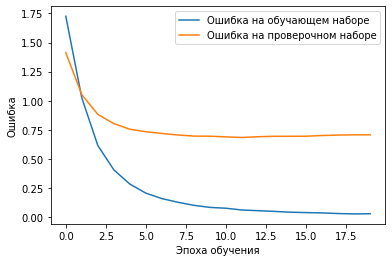

In [ ]:
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

**Embedding + Dense**


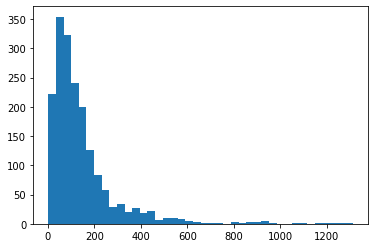

In [ ]:
lenXTrainE = [len(x) for x in xTrainE]
plt.hist(lenXTrainE, 40)
plt.show()

Epoch 1/30
37/37 [==============================] - 3s 47ms/step - loss: 2.3020 - accuracy: 0.1493 - val_loss: 1.8915 - val_accuracy: 0.1965
Epoch 2/30
37/37 [==============================] - 1s 38ms/step - loss: 1.3286 - accuracy: 0.5593 - val_loss: 1.8758 - val_accuracy: 0.1900
Epoch 3/30
37/37 [==============================] - 1s 38ms/step - loss: 0.4453 - accuracy: 0.9038 - val_loss: 1.8539 - val_accuracy: 0.1921
Epoch 4/30
37/37 [==============================] - 1s 39ms/step - loss: 0.1982 - accuracy: 0.9776 - val_loss: 1.8177 - val_accuracy: 0.2489
Epoch 5/30
37/37 [==============================] - 1s 38ms/step - loss: 0.0973 - accuracy: 0.9934 - val_loss: 1.8060 - val_accuracy: 0.2293
Epoch 6/30
37/37 [==============================] - 1s 38ms/step - loss: 0.0658 - accuracy: 0.9967 - val_loss: 1.7852 - val_accuracy: 0.2969
Epoch 7/30
37/37 [==============================] - 1s 38ms/step - loss: 0.0393 - accuracy: 0.9989 - val_loss: 1.7773 - val_accuracy: 0.3057
Epoch 8/30
37

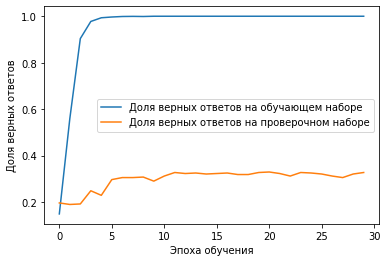

In [ ]:
maxlen = 200

xTrainE = pad_sequences(xTrainE, maxlen=maxlen)
xValE = pad_sequences(xValE, maxlen=maxlen)

#Создаём полносвязную сеть
modelE = Sequential()
#Cлой представления всего словаря слов в векторном представлении
modelE.add(Embedding(maxWordsCount, 50, input_length=maxlen))
#Слой регуляризации Dropout
modelE.add(SpatialDropout1D(0.2))
#Cлой преобразования двумерных данных в одномерные
modelE.add(Flatten())
#Слой пакетной нормализации
modelE.add(BatchNormalization())
#Полносвязный слой
modelE.add(Dense(64, activation="relu"))
#Слой регуляризации Dropout
modelE.add(Dropout(0.2))
#Слой пакетной нормализации
modelE.add(BatchNormalization())
#Выходной полносвязный слой
modelE.add(Dense(nClasses, activation='softmax'))

modelE.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на xTrain
history = modelE.fit(xTrainE, 
                    yTrainE, 
                    epochs=30,
                    batch_size=50,
                    validation_data=(xValE, yValE))


plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

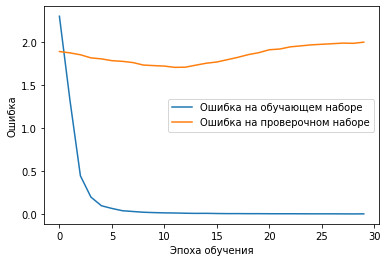

In [ ]:
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

#Глоссарий

**Классификация текстов (документов)** — задача компьютерной лингвистики, заключающаяся в отнесении документа к одной из нескольких категорий на основании содержания документа. 

**Word2vec** — общее название для совокупности моделей на основе искусственных нейронных сетей, предназначенных для получения векторных представлений слов на естественном языке.

---

**Dense** - полносвязный слой. 

**Embedding** - слой представления всего словаря слов в векторном представлении.
**Dropout** - случайная блокировка нейронов для предотвращения переобучения.

**BatchNormalization** - слой пакетной нормализации.

**categorical_crossentropy** - метод определения ошибки нейронной сети для категориальных данных (классов). Категориальная кроссцентропия между выходным результатом и y_train.

**Flatten** - слой преобразования двумерных данных в одномерные.

#Литература

Для более глубокого понимания использования библиотеки важно уметь искать информацию в документации от разработчика. Официальная документация доступна на английском языке.

**Документация Keras** - https://keras.io/ 

**Русскоязычная документация Keras** - https://ru-keras.com/ 


**Документация Tensorflow** - https://www.tensorflow.org/tutorials/keras/text_classification_with_hub?hl=ru

Помимо официальной документации можно найти огромное количество полезной информации и в других источниках.

**Полезная статья на habr:**

https://habr.com/ru/post/324686/

